# Assignment 4: Correlation Analysis and Bootstrapping

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and bootstrapping, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 
5. How to estimate a population parameter based on a sample?
6. How to use the bootstrap to quantify the uncertainty of an estimated value?

**Requirements:**
* Use [pandas](https://pandas.pydata.org/) to manipulate data.
* Use [matplotlib](https://matplotlib.org/) or [seaborn](https://seaborn.pydata.org) to make plots.
* Please pay attention to visualization principles. 


The data can be downloaded from [A4-data.zip](A4-data.zip).


## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct a correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a property_tax_report from this [webpage](https://data.vancouver.ca/datacatalogue/propertyTax.htm). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2019.  You can find the schema information of the dataset from this [webpage](http://data.vancouver.ca/datacatalogue/propertyTaxAttributes.htm). 

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [31]:
import pandas as pd

df = pd.read_csv("property_tax_report_2019.csv")


df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE'] \
                                        +x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)
df.head()

,PID,LEGAL_TYPE,FOLIO,LAND_COORDINATE,ZONE_NAME,ZONE_CATEGORY,LOT,BLOCK,PLAN,DISTRICT_LOT,...,CURRENT_LAND_VALUE,CURRENT_IMPROVEMENT_VALUE,TAX_ASSESSMENT_YEAR,PREVIOUS_LAND_VALUE,PREVIOUS_IMPROVEMENT_VALUE,YEAR_BUILT,BIG_IMPROVEMENT_YEAR,TAX_LEVY,NEIGHBOURHOOD_CODE,HOUSE_PRICE
0,010-543-490,LAND,638035310000,63803531,RS-1,One Family Dwelling,17,C,VAP7743,538,...,3117000.0,40900.0,2020.0,3663000.0,36100.0,1948.0,1958.0,NaN,1,3.1579
1,010-868-810,LAND,643019250000,64301925,RS-1,One Family Dwelling,3,7,VAP6583,140,...,6007000.0,5943000.0,2020.0,7373000.0,6278000.0,2013.0,2015.0,NaN,1,11.9500
2,007-944-055,LAND,23637870000,2363787,RS-1,One Family Dwelling,7,137,VAP6064,540,...,3400000.0,1417000.0,2020.0,4108000.0,1421000.0,2010.0,2011.0,NaN,1,4.8170
3,007-284-250,LAND,24630040000,2463004,RS-1,One Family Dwelling,E,130,VAP17355,540,...,3991000.0,186000.0,2020.0,4813000.0,189000.0,1980.0,1980.0,NaN,1,4.1770
4,005-264-642,STRATA,24637320005,2463732,CD-1 (123),Comprehensive Development,5,NaN,VAS506,540,...,2670000.0,222000.0,2020.0,3281000.0,241000.0,1978.0,1978.0,NaN,1,2.8920


### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose postcode starts with 'V6A'. Furthermore, we remove the houses that were built before 1900.

<img src="img/v6a.png", width=500/>

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

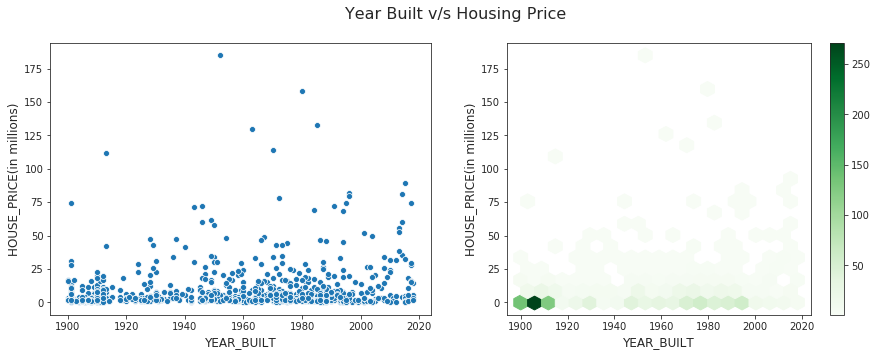

In [32]:
#<-- Write Your Code -->
import matplotlib.pyplot as plt
import seaborn as sns
#Perform the filtering of values
df_filter = df[df['PROPERTY_POSTAL_CODE'].str.startswith('V6A',na=False)]
df_filter = df_filter[df_filter['YEAR_BUILT'] >= 1900]
df_filter = df_filter[df_filter['LEGAL_TYPE'] == 'LAND']

#Setting plot styles
sns.set_style("white",{'xtick.bottom': True,'ytick.left': True})
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Year Built v/s Housing Price", fontsize=16)

#Scatter Plot for data points
figr1 = sns.scatterplot(x='YEAR_BUILT', y='HOUSE_PRICE', data=df_filter,ax=axs[0])
figr1.axes.set_xlabel("YEAR_BUILT",fontsize=12)
figr1.axes.set_ylabel("HOUSE_PRICE(in millions)",fontsize=12)

#Hexbin plot for datapoints
figr2 = plt.hexbin(df_filter["YEAR_BUILT"], df_filter["HOUSE_PRICE"],cmap=plt.cm.Greens, gridsize=20,mincnt=1)
figr2.axes.set_xlabel("YEAR_BUILT",fontsize=12)
figr2.axes.set_ylabel("HOUSE_PRICE(in millions)",fontsize=12)
plt.colorbar()
#Display of plot
plt.show();


Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. We can notice an outlier between the year 1940 and 1960 that had a house price of more than 175 million.Other points seems to have an overlap and hence the plot does not provide a clear picture on the intensity.
2. Majority of house prices recorded in this dataset are from 1900 to 1918 with the peak count around 1910.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insights. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


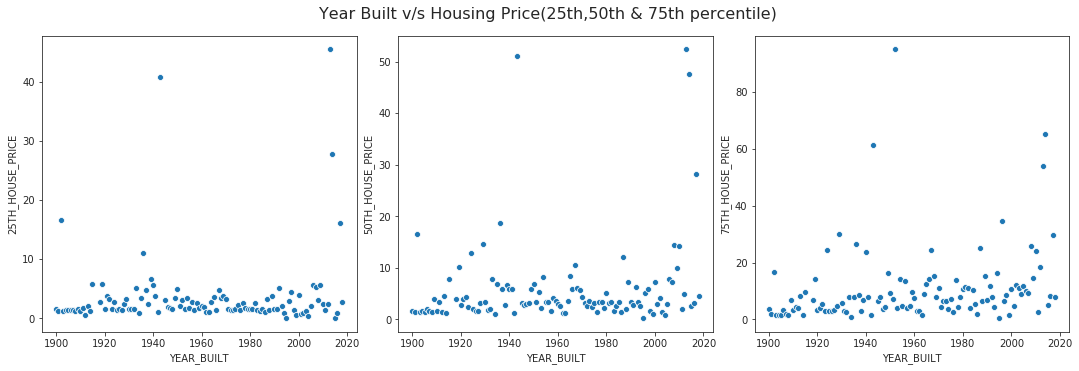

In [33]:
#<-- Write Your Code -->
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.50)

def q3(x):
    return x.quantile(0.75)

# Filter the column values to contain only built year and house price
df_quant = df_filter[['YEAR_BUILT', 'HOUSE_PRICE']]

# Obtain the percentile prices based on each year
df_quant = df_quant.groupby(['YEAR_BUILT']).agg([q1,q2,q3]).stack(level=0)
df_quant = df_quant.reset_index().rename(columns={'q1':'25TH_HOUSE_PRICE','q2':'50TH_HOUSE_PRICE','q3':'75TH_HOUSE_PRICE'})
dfcor = df_quant.drop(columns=['level_1'])


#Setting plot styles
sns.set_style("white",{'xtick.bottom': True,'ytick.left': True})
fig, axs = plt.subplots(1,3,figsize=(15,5))
fig.suptitle("Year Built v/s Housing Price(25th,50th & 75th percentile)", fontsize=16)
fig.tight_layout()

#Scatter Plot for data points
figr1 = sns.scatterplot(x='YEAR_BUILT', y='25TH_HOUSE_PRICE', data=df_quant,ax=axs[0]);
figr2 = sns.scatterplot(x='YEAR_BUILT', y='50TH_HOUSE_PRICE', data=df_quant,ax=axs[1]);
figr3 = sns.scatterplot(x='YEAR_BUILT', y='75TH_HOUSE_PRICE', data=df_quant,ax=axs[2]);

plt.subplots_adjust(top=0.9)

#Display of plot
plt.show();

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. We can note that in all three percentile plots, years around 1940 consistently has one point with a higher price which is an outlier.
2. Majority of prices lie less than 20 million in all three quantiles.

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please implement `calc_pearson()` and `calc_spearman()`, respectively. Note that you are *NOT* allowed to use [corr](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) from Pandas or [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr)/[spearmanr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr) from scipy.stats to do this task. In other words, you need to implement the actual algorithms for pearson and spearman.

In [35]:
import statistics as st
def calc_pearson(df, x, y):
    #<-- Write Your Code -->  
    # Calculate covariance
    covariance = sum((df[x] - st.mean(df[x])) * (df[y] - st.mean(df[y]))) * 1 / (len(df) - 1)
    # Calculate standard deviation for x and y
    stdx = st.stdev(df[x])
    stdy = st.stdev(df[y])
    # Calcuate pearson co-efficient
    p_coeff = round(covariance/(stdx*stdy),6)
    return p_coeff

def calc_spearman(df, x, y):
    #<-- Write Your Code -->
    # Difference in ranks
    sum_di2 = sum(pow((df[x].rank() - df[y].rank()) ,2))
    num = len(df)
    # Spearman co-efficient calculation
    s_coeff = 1 - ((6 * sum_di2)/(num * ((num ** 2) - 1)))
    return round(s_coeff,6)
    


Then, you can use these two functions to compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>. 

In [36]:
print(dfcor.head(10))
print()

for TH in ["25TH", "50TH", "75TH"]:
    print(TH+"_HOUSE_PRICE\t pearson=%f\t spearman=%f"  \
          %(calc_pearson(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE"), \
            calc_spearman(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE")))

   YEAR_BUILT  25TH_HOUSE_PRICE  50TH_HOUSE_PRICE  75TH_HOUSE_PRICE
0      1900.0          1.550200           1.62600            3.5750
1      1901.0          1.189925           1.50700            2.0005
2      1902.0         16.614000          16.61400           16.6140
3      1903.0          1.246150           1.42620            1.5063
4      1904.0          1.454500           1.57920            1.6143
5      1905.0          1.378200           1.49100            1.6730
6      1906.0          1.452350           2.01700            3.1472
7      1907.0          1.448550           1.71800            2.0550
8      1908.0          1.321000           1.47480            1.6970
9      1909.0          1.500225           4.04085            6.8510

25TH_HOUSE_PRICE	 pearson=0.112608	 spearman=0.033614
50TH_HOUSE_PRICE	 pearson=0.185711	 spearman=0.186584
75TH_HOUSE_PRICE	 pearson=0.225439	 spearman=0.389536


<img src="correlation-result.png",align="left",width=500,height=500>

Please write down the **two** most interesting findings that you draw from the result.

 

**Findings**
1. We can note that there is a stronger correlation between 75th percentile of house price and years.Higher spearman correlation compared to pearson signifies the correlation is monotonic
2. It can also be noted that the 50th percentile is same for both pearson and spearman correlation.

## Part 2. Bootstrapping

In reality, it is more often than not that you can only collect a sample of the data. Whenever you derive a conclusion from a sample (e.g., Vancouver's housing price has increased by 10% since last year), you should ALWAYS ask yourself: **"CAN I TRUST IT?"**. In other words, you want to know that if the same analysis was conducted on the full data, would the same conclusion be derived? In Part 2, you will learn how to use bootstrapping to answer this question. 

In [37]:
df_sample = pd.read_csv("property_tax_report_2019_sample.csv")

df_sample['CURRENT_PRICE'] = df_sample.apply(lambda x: x['CURRENT_LAND_VALUE'] \
                                             +x['CURRENT_IMPROVEMENT_VALUE'], axis = 1)

df_sample['PREVIOUS_PRICE'] = df_sample.apply(lambda x: x['PREVIOUS_LAND_VALUE'] \
                                              +x['PREVIOUS_IMPROVEMENT_VALUE'], axis = 1)

df_sample = df_sample[df_sample['LEGAL_TYPE'] == 'STRATA']

### Task 1. Analysis Result Without Bootstrapping

Please compute the median of PREVIOUS_PRICE and CURRENT_PRICE, respectively, and compare them in a bar chart.

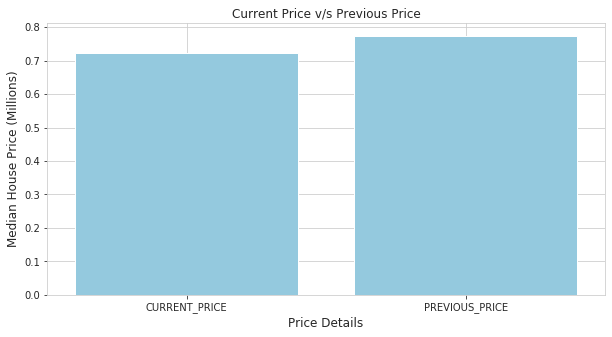

In [38]:
# --- Write your code below ---
import seaborn as sns
import matplotlib.pyplot as plt

median = df_sample[['CURRENT_PRICE','PREVIOUS_PRICE']].median()/1000000.0
df_new = median.reset_index().rename(columns={'index':'Price Details',0:'Median House Price'})

sns.set_style("whitegrid",{'xtick.bottom': True,'ytick.left': True,})
fig,ax = plt.subplots(figsize=(10,5))
figr = sns.barplot(x='Price Details', y='Median House Price', data=df_new, color='SkyBlue')
figr.axes.set_title('Current Price v/s Previous Price')
figr.axes.set_xlabel("Price Details",fontsize=12)
figr.axes.set_ylabel("Median House Price (Millions)",fontsize=12)
ax.yaxis.grid(True)
ax.xaxis.grid(True) 

### Task 2. Analysis Result With Bootstrapping

From the above chart, we find that the median of PREVIOUS_PRICE is about 0.77 M, and the median of CURRENT_PRICE is about 0.72 M. Since the numbers were obtained from the sample, **"CAN WE TRUST THESE NUMBERS?"**

In the following, please implement the bootstrap by yourself, and compute a 95%-confidence interval for each number. [This document](./MIT18_05S14_Reading24.pdf) gives a good tutorial about the bootstrap. You can find the description of the algorithm in Section 7.

Median value of current price is 0.723
95% confidence interval for current price(in millions) is 0.753 , 0.693
Median value of previous price is 0.7735
95% confidence interval for previous price(in millions) is 0.808 , 0.7375


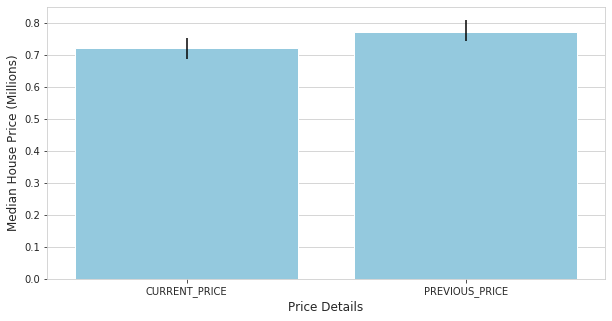

In [39]:
import statistics as st
import numpy as np
# --- Write your code below ---

# Obtain individual median scores to perform bootstrap
median_cur = df_sample['CURRENT_PRICE'].median()/1000000.0
median_pre = df_sample['PREVIOUS_PRICE'].median()/1000000.0

# Create a new dataframe to store current and previous price differences for all samples
df_bootstrap = pd.DataFrame(columns=['diff_cur','diff_prev'])

# Perform resampling 1000 times
for i in range(0,1000):
    # Resampling which has entire records . Since the entire dataset is less we are giving full number for resample
    dfresamp = df_sample.sample(n=len(df_sample),replace=True)
    # Obtain median for each sample
    median_csamp = dfresamp['CURRENT_PRICE'].median()/1000000.0
    median_psamp = dfresamp['PREVIOUS_PRICE'].median()/1000000.0
    # Subtract median price of original set from sample set
    diff_c = (median_csamp - median_cur)
    diff_p = (median_psamp - median_pre)
    # Append the dataframe with the differences
    df_bootstrap = df_bootstrap.append({'diff_cur':diff_c,'diff_prev':diff_p},ignore_index=True)

# Obtain the 25th and 975th values of the current price set to obtain 95% confidence interval
df_cur = df_bootstrap['diff_cur'].sort_values().reset_index()
cur_25 = df_cur['diff_cur'].iloc[25]
cur_97 = df_cur['diff_cur'].iloc[975]

# Obtain the 25th and 975th values of the previous price set to obtain 95% confidence interval
df_pre = df_bootstrap['diff_prev'].sort_values().reset_index()
pre_25 = df_pre['diff_prev'].iloc[25]
pre_97 = df_pre['diff_prev'].iloc[975]

#Form an array to plot both the quantile values to visualize the interval
interval = np.array([[cur_25,cur_97],[pre_25,pre_97]])
#Print the confidence interval values for both current price and previous price
confi_cur = np.array([(median_cur - cur_25),(median_cur - cur_97)])
confi_pre = np.array([(median_pre - pre_25),(median_pre - pre_97)])

# Displaying the confidence intervals
print("Median value of current price is",median_cur)
print("95% confidence interval for current price(in millions) is",round(confi_cur[0],4),",",round(confi_cur[1],4))
print("Median value of previous price is",median_pre)
print("95% confidence interval for previous price(in millions) is",round(confi_pre[0],4),",",round(confi_pre[1],4))

# Dataframe with current and previous price alone for plotting. Prices divided by million
median = df_sample[['CURRENT_PRICE','PREVIOUS_PRICE']].median()/1000000.0
df_med = median.reset_index().rename(columns={'index':'Price Details',0:'Median House Price'})

# Producing the plots with confidence intervals lines
sns.set_style("whitegrid",{'xtick.bottom': True,'ytick.left': True,})
fig,ax = plt.subplots(figsize=(10,5))
figr.axes.set_title('Current Price v/s Previous Price')
figr = sns.barplot(x='Price Details', y='Median House Price',yerr=interval, data=df_med,capsize=7,color='SkyBlue')
figr.axes.set_xlabel("Price Details",fontsize=12)
figr.axes.set_ylabel("Median House Price (Millions)",fontsize=12);

## Submission

Complete the code in this notebook, and submit it to the CourSys activity Assignment 4.